In [3]:
# Import libraries that are required to run your project
# You are allowed to add more libraries as you need

import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import skew
from scipy.stats import kurtosis

import os
import zipfile
import shutil
import matplotlib.pyplot as plt


Useful to initiate new conda environment given the yml file (Note I adjusted it to work for windows)
```bash
conda env create -f project1_base.yml -n ml4g_project1
```

Note: Maybe we rather make a new one, since it hasn't been updated for 4 years

In [51]:
import os
import zipfile
import shutil

# Define paths
source_dir = 'ML4G_Project_1_Data'  # Path to directory with zip files
target_dir = 'data'  # Target directory for extracted files

# Create target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Create folders for each cell line
cell_lines = ['X1', 'X2', 'X3']
for cell_line in cell_lines:
    cell_line_dir = os.path.join(target_dir, cell_line)
    os.makedirs(cell_line_dir, exist_ok=True)

# Get all zip files in the source directory (excluding sample.zip)
zip_files = [f for f in os.listdir(source_dir) if f.endswith('.zip') and f != 'sample.zip']

# Process each zip file separately
for zip_file in zip_files:
    zip_path = os.path.join(source_dir, zip_file)
    zip_name = os.path.splitext(zip_file)[0]
    print(f"Processing {zip_file}...")
    
    # Extract to a unique temporary directory for this zip file
    temp_extract_dir = os.path.join(target_dir, f'temp_{zip_name}')
    os.makedirs(temp_extract_dir, exist_ok=True)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_dir)
    
    # Walk through all extracted files from this zip and organize them
    for root, dirs, files in os.walk(temp_extract_dir):
        if 'MACOSX' in root:
            continue
        for file in files:
            source_file = os.path.join(root, file)
            
            # Handle CAGE-train files separately
            if 'CAGE-train' in root or file.endswith('.tsv'):
                # Keep CAGE-train files in their own folder
                cage_train_target = os.path.join(target_dir, 'CAGE-train')
                os.makedirs(cage_train_target, exist_ok=True)
                
                # Preserve the relative path structure for CAGE files
                rel_path = os.path.relpath(source_file, temp_extract_dir)
                target_file = os.path.join(cage_train_target, rel_path)
                os.makedirs(os.path.dirname(target_file), exist_ok=True)
                shutil.copy2(source_file, target_file)
                print(f"  Copied {file} to CAGE-train/")
                continue
            
            # Determine which cell line this file belongs to
            cell_line_found = False
            for cell_line in cell_lines:
                if cell_line in file:
                    file_lower = file.lower()
                    
                    # Get file extension (handle both .bw and .bigwig)
                    if file.endswith('.bw') or file.endswith('.bigwig'):
                        ext = '.bw'
                    elif file.endswith('.bed'):
                        ext = '.bed'
                    else:
                        continue
                    
                    # Determine the mark/assay type from the zip file name
                    zip_lower = zip_name.lower()
                    if 'dnase' in zip_lower:
                        data_type = 'DNase'
                    elif 'h3k27ac' in zip_lower:
                        data_type = 'H3K27ac'
                    elif 'h3k27me3' in zip_lower:
                        data_type = 'H3K27me3'
                    elif 'h3k36me3' in zip_lower:
                        data_type = 'H3K36me3'
                    elif 'h3k4me1' in zip_lower:
                        data_type = 'H3K4me1'
                    elif 'h3k4me3' in zip_lower:
                        data_type = 'H3K4me3'
                    elif 'h3k9me3' in zip_lower:
                        data_type = 'H3K9me3'
                    else:
                        # Skip if we can't identify the data type
                        continue
                    
                    # Create new filename: {data_type}_{cell_line}{ext}
                    new_filename = f"{data_type}_{cell_line}{ext}"
                    target_file = os.path.join(target_dir, cell_line, new_filename)
                    
                    # Copy the file to the new location
                    shutil.copy2(source_file, target_file)
                    print(f"  Copied {file} -> {cell_line}/{new_filename}")
                    cell_line_found = True
                    break
    
    # Clean up this zip's temporary directory
    shutil.rmtree(temp_extract_dir)
    print(f"  Cleaned up temp_{zip_name}")

print(f"\nAll {len(zip_files)} zip files have been extracted and organized in {target_dir}")
print(f"Structure: data/{'{X1,X2,X3}'}/{'{DataType}_{CellLine}.{bw,bed}'}")

Processing H3K9me3-bigwig.zip...
  Copied X1.bw -> X1/H3K9me3_X1.bw
  Copied X2.bw -> X2/H3K9me3_X2.bw
  Copied X3.bigwig -> X3/H3K9me3_X3.bw
  Cleaned up temp_H3K9me3-bigwig

All 1 zip files have been extracted and organized in data
Structure: data/{X1,X2,X3}/{DataType}_{CellLine}.{bw,bed}


## Work Package 1.1 - Modeling Choices & Data Pre-processing

In [1]:
# Data paths etc.
data_paths_bw = {
   'X1': {
        'DNase': 'data/X1/DNase_X1.bw',
        'H3K27ac': 'data/X1/H3K27ac_X1.bw',
        'H3K27me3': 'data/X1/H3K27me3_X1.bw',
        'H3K36me3': 'data/X1/H3K36me3_X1.bw',
        'H3K4me1': 'data/X1/H3K4me1_X1.bw',
        'H3K4me3': 'data/X1/H3K4me3_X1.bw',
        'H3K9me3': 'data/X1/H3K9me3_X1.bw'
    },
    'X2': {
        'DNase': 'data/X2/DNase_X2.bw',
        'H3K27ac': 'data/X2/H3K27ac_X2.bw',
        'H3K27me3': 'data/X2/H3K27me3_X2.bw',
        'H3K36me3': 'data/X2/H3K36me3_X2.bw',
        'H3K4me1': 'data/X2/H3K4me1_X2.bw',
        'H3K4me3': 'data/X2/H3K4me3_X2.bw',
        'H3K9me3': 'data/X2/H3K9me3_X2.bw'
    },
    'X3': {
        'DNase': 'data/X3/DNase_X3.bw',
        'H3K27ac': 'data/X3/H3K27ac_X3.bw',
        'H3K27me3': 'data/X3/H3K27me3_X3.bw',
        'H3K36me3': 'data/X3/H3K36me3_X3.bw',
        'H3K4me1': 'data/X3/H3K4me1_X3.bw',
        'H3K4me3': 'data/X3/H3K4me3_X3.bw',
        'H3K9me3': 'data/X3/H3K9me3_X3.bw'
    }
}

data_paths_bed = {
     'X1': {
        'DNase': 'data/X1/DNase_X1.bed',
        'H3K27ac': 'data/X1/H3K27ac_X1.bed',
        'H3K27me3': 'data/X1/H3K27me3_X1.bed',
        'H3K36me3': 'data/X1/H3K36me3_X1.bed',
        'H3K4me1': 'data/X1/H3K4me1_X1.bed',
        'H3K4me3': 'data/X1/H3K4me3_X1.bed',
        'H3K9me3': 'data/X1/H3K9me3_X1.bed'
    },
    'X2': {
        'DNase': 'data/X2/DNase_X2.bed',
        'H3K27ac': 'data/X2/H3K27ac_X2.bed',
        'H3K27me3': 'data/X2/H3K27me3_X2.bed',
        'H3K36me3': 'data/X2/H3K36me3_X2.bed',
        'H3K4me1': 'data/X2/H3K4me1_X2.bed',
        'H3K4me3': 'data/X2/H3K4me3_X2.bed',
        'H3K9me3': 'data/X2/H3K9me3_X2.bed'
    },
    'X3': {
        'DNase': 'data/X3/DNase_X3.bed',
        'H3K27ac': 'data/X3/H3K27ac_X3.bed',
        'H3K27me3': 'data/X3/H3K27me3_X3.bed',
        'H3K36me3': 'data/X3/H3K36me3_X3.bed',
        'H3K4me1': 'data/X3/H3K4me1_X3.bed',
        'H3K4me3': 'data/X3/H3K4me3_X3.bed',
        'H3K9me3': 'data/X3/H3K9me3_X3.bed'
    }
}

gene_paths = {
    'X1': {
        'train':{
            'info': 'data/CAGE-train/CAGE-train/X1_train_info.tsv',
            'target': 'data/CAGE-train/CAGE-train/X1_train_y.tsv'
        },
        'validation':{
            'info': 'data/CAGE-train/CAGE-train/X1_val_info.tsv',
            'target': 'data/CAGE-train/CAGE-train/X1_val_y.tsv'
        }
    },
    'X2': {
        'train':{
            'info': 'data/CAGE-train/CAGE-train/X2_train_info.tsv',
            'target': 'data/CAGE-train/CAGE-train/X2_train_y.tsv'
        },
        'validation':{
            'info': 'data/CAGE-train/CAGE-train/X2_val_info.tsv',
            'target': 'data/CAGE-train/CAGE-train/X2_val_y.tsv'
        }
    },
    'X3': 'X3_test_info.tsv'
}

(0.0, 19519.8335271173, 50.09205731530775, 0.0, 322.32000528244527)
(0.0, 4906.45991593704, 64.20210206850176, 0.0, 294.5626480580007)
(0.0, 19512.4842719895, 51.73973263003801, 0.0, 339.45074543726287)
(0.0, 4904.61262427614, 61.473903323577275, 0.096070920321949, 270.1200550969448)
(0.480535524165267, 19519.8335271173, 121.12493075060051, 16.9148504506174, 492.5519897098709)
(0.480535524165267, 4906.45991593704, 138.05550052638614, 17.5876001844488, 419.9784133688404)
(0.096070920321949, 19512.4842719895, 104.1343985845069, 7.589602705433969, 475.87403514466314)
(0.096070920321949, 4904.61262427614, 110.72033317585908, 10.5678012354144, 354.91411199412727)
[0.         0.48053552 1.05717815 1.63382078 2.11435631]
[0.         0.48053552 1.05717815 1.63382078 2.11435631]
[0.         0.09607092 0.28821276 0.4803546  0.67249644]
[0.         0.09607092 0.28821276 0.4803546  0.67249644]


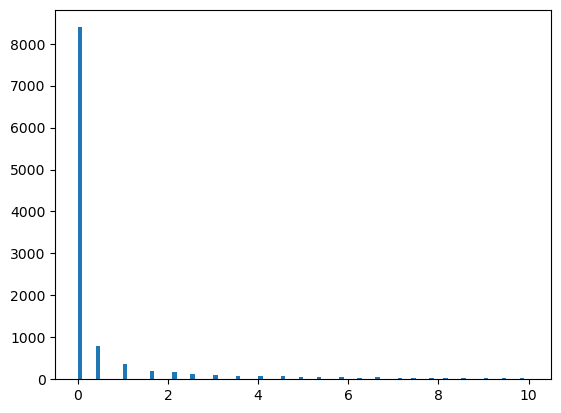

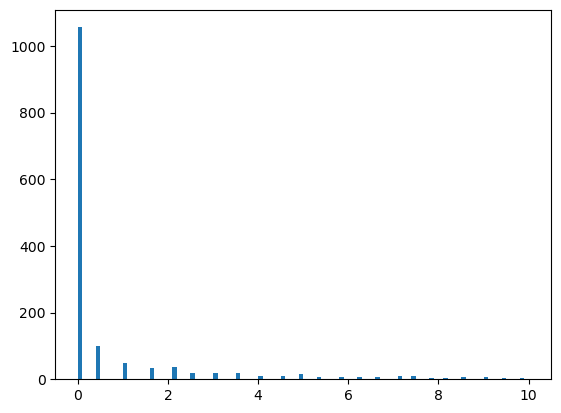

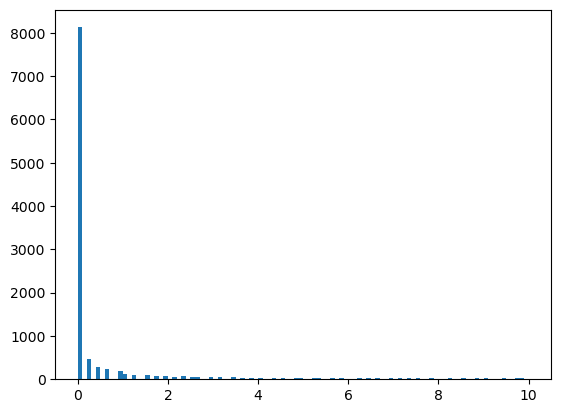

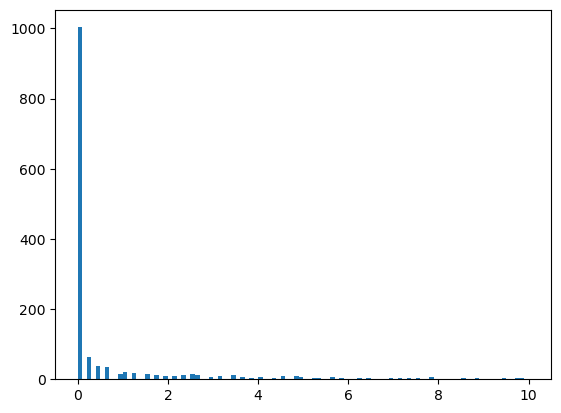

In [4]:
gene_target_df_X1 = pd.read_csv(gene_paths['X1']['train']['target'], sep='\t')
gene_target_df_X1_val = pd.read_csv(gene_paths['X1']['validation']['target'], sep='\t')
gene_target_df_X2 = pd.read_csv(gene_paths['X2']['train']['target'], sep='\t')
gene_target_df_X2_val = pd.read_csv(gene_paths['X2']['validation']['target'], sep='\t')

def get_stats(values):
    return np.min(values), np.max(values), np.mean(values), np.median(values), np.std(values)

np.set_printoptions(suppress=True)
print(get_stats(gene_target_df_X1['gex']))
print(get_stats(gene_target_df_X1_val['gex']))
print(get_stats(gene_target_df_X2['gex']))
print(get_stats(gene_target_df_X2_val['gex']))
print(get_stats(gene_target_df_X1['gex'][gene_target_df_X1['gex']>0]))
print(get_stats(gene_target_df_X1_val['gex'][gene_target_df_X1_val['gex']>0]))
print(get_stats(gene_target_df_X2['gex'][gene_target_df_X2['gex']>0]))
print(get_stats(gene_target_df_X2_val['gex'][gene_target_df_X2_val['gex']>0]))

print(np.unique(gene_target_df_X1['gex'])[:5])
print(np.unique(gene_target_df_X1_val['gex'])[:5])
print(np.unique(gene_target_df_X2['gex'])[:5])
print(np.unique(gene_target_df_X2_val['gex'])[:5])

# print(gene_target_df)
plt.hist(gene_target_df_X1['gex'], range=(0,10), bins=100)
plt.show()
plt.hist(gene_target_df_X1_val['gex'], range=(0,10), bins=100)
plt.show()
plt.hist(gene_target_df_X2['gex'], range=(0,10), bins=100)
plt.show()
plt.hist(gene_target_df_X2_val['gex'], range=(0,10), bins=100)
plt.show()

      gene_name    chr  gene_start   gene_end  TSS_start    TSS_end strand
0       SLC20A1   chr2   112645939  112663825  112658362  112658412      +
1      C11orf58  chr11    16613132   16758340   16738643   16738693      +
2        ZSCAN9   chr6    28224886   28233487   28225263   28225313      +
3          CD19  chr16    28931965   28939342   28931956   28932006      +
4       TMEM123  chr11   102396332  102470384  102452789  102452839      -
...         ...    ...         ...        ...        ...        ...    ...
14305     ACOX1  chr17    75941507   75979177   75955565   75955589      -
14306     MLXIP  chr12   122078756  122147344  122127887  122127937      +
14307     ASGR2  chr17     7101322    7115700    7114614    7114653      -
14308     OR5A1  chr11    59436469   59451380   59443143   59443193      +
14309      TLR3   chr4   186069155  186088073  186069154  186069204      +

[14310 rows x 7 columns]
gene_name    SLC20A1
gex              0.0
Name: 0, dtype: object


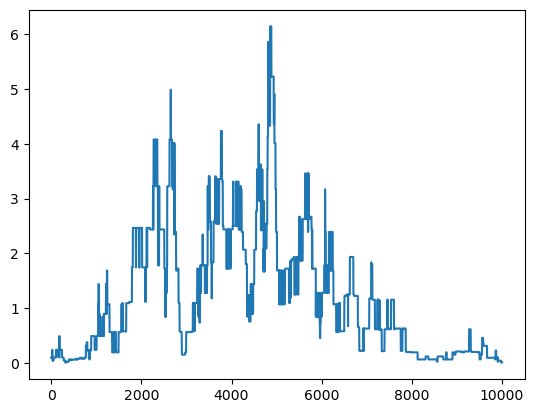

gene_name       C11orf58
gex          2239.103328
Name: 1, dtype: object


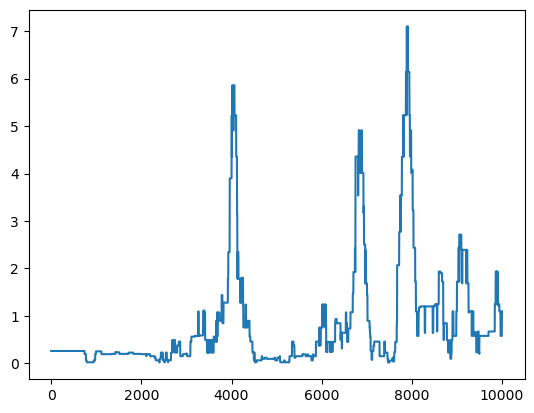

gene_name       ZSCAN9
gex          19.798064
Name: 2, dtype: object


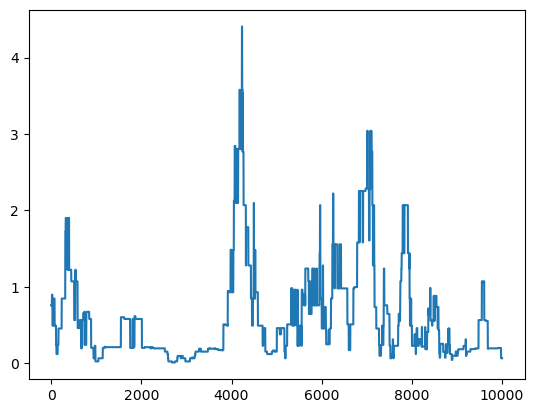

gene_name          CD19
gex          411.530623
Name: 3, dtype: object


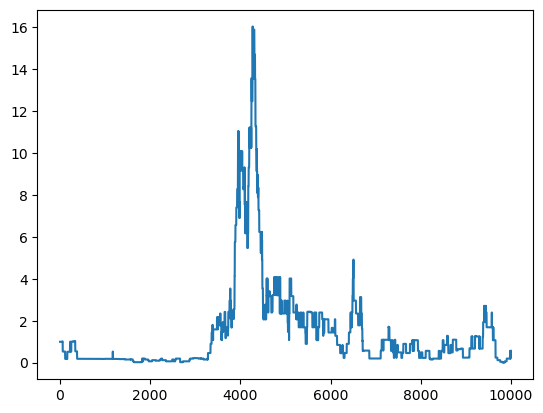

gene_name      TMEM123
gex          34.214129
Name: 4, dtype: object


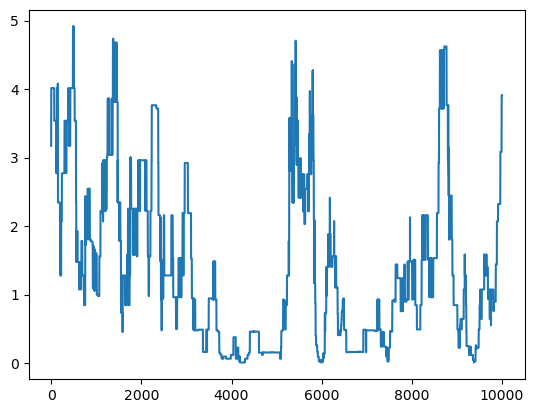

In [7]:
import pybigtools
import matplotlib.pyplot as plt

# get_dataset('X1', 'train')
gene_info_df = pd.read_csv(gene_paths['X1']['train']['info'], sep='\t')
gene_target_df = pd.read_csv(gene_paths['X1']['train']['target'], sep='\t')
print(gene_info_df)
# print(gene_target_df)
# print((gene_info_df['strand']=='+').astype(int))
b = pybigtools.open('data/X1/H3K4me1_X1.bw')
for i in range(5):
    row = gene_info_df.iloc[i]
    print(gene_target_df.iloc[i])
    # print(row)
    plt.plot(b.values(row['chr'], row['TSS_start']-5000, row['TSS_start']+5000))
    plt.show()

      gene_name    chr  gene_start   gene_end  TSS_start    TSS_end strand
0       SLC20A1   chr2   112645939  112663825  112658362  112658412      +
1      C11orf58  chr11    16613132   16758340   16738643   16738693      +
2        ZSCAN9   chr6    28224886   28233487   28225263   28225313      +
3          CD19  chr16    28931965   28939342   28931956   28932006      +
4       TMEM123  chr11   102396332  102470384  102452789  102452839      -
...         ...    ...         ...        ...        ...        ...    ...
14305     ACOX1  chr17    75941507   75979177   75955565   75955589      -
14306     MLXIP  chr12   122078756  122147344  122127887  122127937      +
14307     ASGR2  chr17     7101322    7115700    7114614    7114653      -
14308     OR5A1  chr11    59436469   59451380   59443143   59443193      +
14309      TLR3   chr4   186069155  186088073  186069154  186069204      +

[14310 rows x 7 columns]
{'version': 4, 'isCompressed': True, 'primaryDataSize': 47583322, 'zoomLev

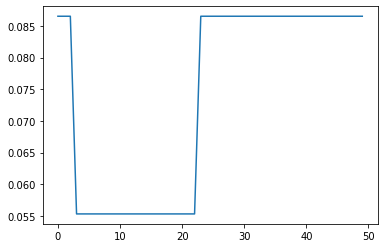

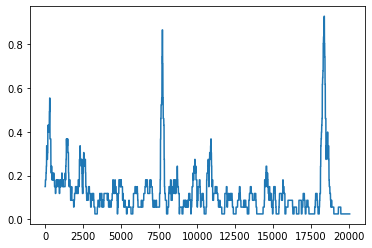

In [7]:
import pybigtools
import matplotlib.pyplot as plt

# get_dataset('X1', 'train')
gene_info_df = pd.read_csv(gene_paths['X1']['train']['info'], sep='\t')
gene_target_df = pd.read_csv(gene_paths['X1']['train']['target'], sep='\t')
print(gene_info_df)
# print(gene_target_df)
# print((gene_info_df['strand']=='+').astype(int))

b = pybigtools.open('data/X1/DNase_X1.bw')
print(b.info())
print(b.values('chr2', -10, 40, oob=0.0))
print(b.chroms())
print()

plt.plot(b.values('chr2', 112658362, 112658412))
plt.show()
plt.plot(b.values('chr2', 112658362-10000, 112658412+10000))
plt.show()

b.close()

In [42]:
# Approach 1: Use bw files, compute average, min, max, std over a region that spans the transcription start site (TSS) +/- 10kb
# import pyBigWig
import pybigtools

# Idea: Function that given cell line and type (train/val) extracts features and targets
def get_dataset(cell_line, set_type, window=10000, num_bins=10):

    gene_info_df = pd.read_csv(gene_paths[cell_line][set_type]['info'], sep='\t')
    gene_target_df = pd.read_csv(gene_paths[cell_line][set_type]['target'], sep='\t')
    
    # Pass window (in bases) through to feature extraction so you can vary it between runs
    features = extract_all_features(gene_info_df, cell_line, window=window, num_bins=num_bins)
    # targets = gene_target_df['gex'].values
    targets = np.log2(gene_target_df['gex'].values + 0.001) # log scaling targets
    # targets = np.arcsinh(gene_target_df['gex'].values) # arcsinh scaling targets

    # features = (features+0.001).apply(np.log2) # log scale features
    
    return features, targets


In [ ]:

def extract_all_features(gene_info_df, cell_line, window=10000, bw_paths=None):
    """
    Extract summary statistics from bigWig files for each gene in `gene_info_df` and
    each mark defined in `bw_paths` (or `data_paths_bw[cell_line]` by default).

    Parameters:
    - gene_info_df: pd.DataFrame with at least columns ['chr', 'tss'] and optionally 'gene_name'.
    - cell_line: one of the keys in data_paths_bw (e.g. 'X1').
    - window: int, number of bases upstream/downstream of TSS to include (default 10000 bases).
    - bw_paths: optional dict of mark->path. If None, uses data_paths_bw[cell_line].

    Returns:
    - pd.DataFrame: index matches gene order (uses 'gene_name' if present), columns like '<MARK>_avg', '<MARK>_min', '<MARK>_max', '<MARK>_std'.
    """
    if bw_paths is None:
        bw_paths = data_paths_bw.get(cell_line, {})

    # Prepare index / gene identifiers
    if 'gene_name' in gene_info_df.columns:
        gene_names = gene_info_df['gene_name'].astype(str).tolist()
    else:
        gene_names = gene_info_df.index.astype(str).tolist()

    feature_frames = []

    for mark, path in bw_paths.items():
        print(f"Extracting features for {mark} from {path}...")

        # Default fallback columns for this mark (will keep gene order)
        # cols = [f"{mark}_avg", f"{mark}_min", f"{mark}_max", f"{mark}_std"]
        features = ["avg", "min", "max", "std", "med", "sum", "w_sum"]
        cols = [mark+"_"+feat_name for feat_name in features]
        rows = []

        # Check file exists
        try:
            # bw = pyBigWig.open(path)
            bw = pybigtools.open(path)
            if bw is None:
                raise FileNotFoundError(f"Could not open bigWig: {path}")
        except Exception as e:
            print(f"  Warning: cannot open {path}: {e}. Filling zeros for this mark.")
            # fill zeros for all genes if the file can't be opened
            rows = [[0.0]*len(cols) for _ in range(len(gene_names))]
            feature_frames.append(pd.DataFrame(rows, columns=cols, index=gene_names))
            continue

        # iterate genes in order and extract statistics
        # for _, row in gene_info_df.iterrows():
        #     chrom = str(row['chr'])
        #     start = max(0, int(row['TSS_start']) - window)
        #     end = int(row['TSS_end']) + window
            
        for i, row in enumerate(gene_info_df.itertuples(index=False)):
            chrom = str(getattr(row, 'chr')) if 'chr' in gene_info_df.columns else str(row[0])
            # start = max(0, int(getattr(row, 'TSS_start')) - window)
            tss_start=int(getattr(row, 'TSS_start'))
            tss_end=int(getattr(row, 'TSS_end'))
            start = tss_start - window
            end = tss_end + window
            # end = tss_start + window
            wide_window=10000
            wide_bins=(wide_window*2)//10
            EPS_DIST = 10

            try:
                # values = bw.values(chrom, start, end, numpy=True)
                # values = bw.values(chrom, start, end)
                values = bw.values(chrom, start, end, oob=0.0)

                wide_values = bw.values(chrom, tss_start-wide_window, tss_start + wide_window, oob=0.0, bins=wide_bins)
                # relative_pos=np.arange(len(wide_values))
                relative_pos=np.arange(wide_window*2)[::((wide_window*2)//wide_bins)]
                distance_to_tss=np.abs(relative_pos-wide_window)
                weights=1.0/(distance_to_tss+EPS_DIST)
                close_mask=distance_to_tss<=1000
                weights[close_mask]=0.0


                # pyBigWig may return None if region is invalid
                if values is None:
                    vals = np.array([], dtype=float)
                else:
                    # vals = np.asarray(values, dtype=float)
                    vals = values
                # replace NaNs and handle empty arrays
                if vals.size == 0:
                    rows.append([0.0]*len(cols))
                else:
                    # vals = np.nan_to_num(vals, nan=0.0)
                    rows.append([np.mean(vals), np.min(vals), np.max(vals), np.std(vals), np.median(vals), np.sum(vals), np.sum(wide_values*weights)])
                    # rows.append([np.mean(vals), np.min(vals), np.max(vals), np.std(vals), np.median(vals), np.sum(vals), 0.0])
            except Exception as e:
                # keep alignment with genes even when extraction fails for a gene
                print(f"  Warning: failed for {chrom}:{start}-{end} ({e}). Using zeros.")
                rows.append([0.0]*len(cols))

        # close bigWig handle
        try:
            bw.close()
        except Exception:
            pass

        # create dataframe for this mark, use gene_names as index to preserve order
        mark_df = pd.DataFrame(rows, columns=cols, index=gene_names)
        feature_frames.append(mark_df)

    # concat horizontally and ensure index is gene names
    if feature_frames:
        all_features_df = pd.concat(feature_frames, axis=1)
        # all_features_df['strand'] = (gene_info_df['strand']=='+').astype(int).values
        all_features_df.index.name = 'gene_name'
    else:
        all_features_df = pd.DataFrame(index=gene_names)

    return all_features_df

In [43]:
def calculate_features(vals, wide_values=None, weights=None, num_bins=10, bin_stats=['mean']):
    """
    Calculate all features for a given signal array.
    
    Parameters:
    - vals: numpy array of signal values in the main window
    - wide_values: optional array for weighted sum calculation
    - weights: optional weights for wide_values
    - num_bins: number of bins for spatial features
    - bin_stats: list of statistics to calculate per bin. 
                 Options: 'mean', 'min', 'max', 'std', 'median', 'sum'
    
    Returns:
    - list of feature values
    - list of feature names
    """
    features = []
    feature_names = []
    
    # Basic statistics (global)
    if vals.size == 0:
        basic_features = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        basic_names = ["avg", "min", "max", "std", "med", "sum"]
    else:
        basic_features = [
            np.mean(vals),
            np.min(vals),
            np.max(vals),
            np.std(vals),
            np.median(vals),
            np.sum(vals)
        ]
        basic_names = ["avg", "min", "max", "std", "med", "sum"]
    
    features.extend(basic_features)
    feature_names.extend(basic_names)
    
    # Weighted sum (distance-weighted)
    if wide_values is not None and weights is not None:
        w_sum = np.sum(wide_values * weights)
    else:
        w_sum = 0.0
    features.append(w_sum)
    feature_names.append("w_sum")
    
    # Binned features with multiple statistics
    bin_size = len(vals) // num_bins if len(vals) > 0 else 0
    
    # Mapping of stat names to functions
    stat_functions = {
        'mean': np.mean,
        'min': np.min,
        'max': np.max,
        'std': np.std,
        'median': np.median,
        'sum': np.sum
    }
    
    if bin_size > 0 and len(vals) >= num_bins:
        for b in range(num_bins):
            bin_start = b * bin_size
            bin_end = (b + 1) * bin_size if b < num_bins - 1 else len(vals)
            bin_vals = vals[bin_start:bin_end]
            
            if len(bin_vals) > 0:
                for stat_name in bin_stats:
                    stat_func = stat_functions[stat_name]
                    features.append(stat_func(bin_vals))
                    feature_names.append(f"bin{b}_{stat_name}")
            else:
                # Empty bin
                for stat_name in bin_stats:
                    features.append(0.0)
                    feature_names.append(f"bin{b}_{stat_name}")
    else:
        # Not enough data for bins
        for b in range(num_bins):
            for stat_name in bin_stats:
                features.append(0.0)
                feature_names.append(f"bin{b}_{stat_name}")
    
    return features, feature_names


def extract_all_features(gene_info_df, cell_line, window=10000, bw_paths=None, 
                         num_bins=5, bin_stats=['mean', 'max', 'std']):
    """
    Extract summary statistics from bigWig files for each gene in `gene_info_df` and
    each mark defined in `bw_paths` (or `data_paths_bw[cell_line]` by default).

    Parameters:
    - gene_info_df: pd.DataFrame with at least columns ['chr', 'tss'] and optionally 'gene_name'.
    - cell_line: one of the keys in data_paths_bw (e.g. 'X1').
    - window: int, number of bases upstream/downstream of TSS to include (default 10000 bases).
    - bw_paths: optional dict of mark->path. If None, uses data_paths_bw[cell_line].
    - num_bins: int, number of bins for spatial features (default 10).
    - bin_stats: list of statistics to calculate per bin (default ['mean', 'max', 'std']).
                 Options: 'mean', 'min', 'max', 'std', 'median', 'sum'

    Returns:
    - pd.DataFrame: index matches gene order (uses 'gene_name' if present), 
                    columns like '<MARK>_avg', '<MARK>_bin0_mean', '<MARK>_bin0_max', etc.
    """
    if bw_paths is None:
        bw_paths = data_paths_bw.get(cell_line, {})

    # Prepare index / gene identifiers
    if 'gene_name' in gene_info_df.columns:
        gene_names = gene_info_df['gene_name'].astype(str).tolist()
    else:
        gene_names = gene_info_df.index.astype(str).tolist()

    feature_frames = []

    for mark, path in bw_paths.items():
        print(f"Extracting features for {mark} from {path}...")

        # We'll determine column names from the first successful feature calculation
        cols = None
        rows = []

        # Check file exists
        try:
            bw = pybigtools.open(path)
            if bw is None:
                raise FileNotFoundError(f"Could not open bigWig: {path}")
        except Exception as e:
            print(f"  Warning: cannot open {path}: {e}. Filling zeros for this mark.")
            # Get feature names from a dummy calculation
            dummy_features, dummy_names = calculate_features(
                np.array([]), num_bins=num_bins, bin_stats=bin_stats
            )
            cols = [mark + "_" + name for name in dummy_names]
            rows = [[0.0] * len(cols) for _ in range(len(gene_names))]
            feature_frames.append(pd.DataFrame(rows, columns=cols, index=gene_names))
            continue

        # Iterate genes in order and extract statistics
        for i, row in enumerate(gene_info_df.itertuples(index=False)):
            chrom = str(getattr(row, 'chr')) if 'chr' in gene_info_df.columns else str(row[0])
            tss_start = int(getattr(row, 'TSS_start'))
            tss_end = int(getattr(row, 'TSS_end'))
            start = tss_start - window
            end = tss_end + window
            
            # Wide window for weighted features
            wide_window = 10000
            wide_bins = (wide_window * 2) // 10
            EPS_DIST = 10

            try:
                # Extract main window values
                values = bw.values(chrom, start, end, oob=0.0)
                
                # Extract wide window values for weighted sum
                wide_values = bw.values(
                    chrom, 
                    tss_start - wide_window, 
                    tss_start + wide_window, 
                    oob=0.0, 
                    bins=wide_bins
                )
                
                # Calculate distance weights
                relative_pos = np.arange(wide_window * 2)[::((wide_window * 2) // wide_bins)]
                distance_to_tss = np.abs(relative_pos - wide_window)
                weights = 1.0 / (distance_to_tss + EPS_DIST)
                close_mask = distance_to_tss <= 1000
                weights[close_mask] = 0.0

                # Handle None values from bigWig
                if values is None:
                    vals = np.array([], dtype=float)
                else:
                    vals = values
                
                # Calculate all features
                gene_features, feature_names = calculate_features(
                    vals, 
                    wide_values=wide_values, 
                    weights=weights,
                    num_bins=num_bins,
                    bin_stats=bin_stats
                )
                
                # Set column names on first successful extraction
                if cols is None:
                    cols = [mark + "_" + name for name in feature_names]
                
                rows.append(gene_features)
                
            except Exception as e:
                # Keep alignment with genes even when extraction fails
                print(f"  Warning: failed for {chrom}:{start}-{end} ({e}). Using zeros.")
                if cols is None:
                    # Get column names from dummy calculation
                    dummy_features, dummy_names = calculate_features(
                        np.array([]), num_bins=num_bins, bin_stats=bin_stats
                    )
                    cols = [mark + "_" + name for name in dummy_names]
                rows.append([0.0] * len(cols))

        # Close bigWig handle
        try:
            bw.close()
        except Exception:
            pass

        # Create dataframe for this mark
        mark_df = pd.DataFrame(rows, columns=cols, index=gene_names)
        feature_frames.append(mark_df)

    # Concatenate horizontally and ensure index is gene names
    if feature_frames:
        all_features_df = pd.concat(feature_frames, axis=1)
        all_features_df.index.name = 'gene_name'
    else:
        all_features_df = pd.DataFrame(index=gene_names)

    return all_features_df

In [29]:
X, y = get_dataset('X1', 'validation', window=100)
print(X)
print(y)

Extracting features for DNase from data/X1/DNase_X1.bw...
Extracting features for H3K27ac from data/X1/H3K27ac_X1.bw...
Extracting features for H3K27me3 from data/X1/H3K27me3_X1.bw...
Extracting features for H3K36me3 from data/X1/H3K36me3_X1.bw...
Extracting features for H3K4me1 from data/X1/H3K4me1_X1.bw...
Extracting features for H3K4me3 from data/X1/H3K4me3_X1.bw...
Extracting features for H3K9me3 from data/X1/H3K9me3_X1.bw...
           DNase_avg  DNase_min  DNase_max  DNase_std  DNase_med   DNase_sum  \
gene_name                                                                      
ECH1        0.075922   0.024102   0.148969   0.040273   0.086535   18.980406   
CAMSAP3     0.163204   0.055319   0.242619   0.039388   0.148969   40.800928   
MISP        0.034965   0.024102   0.055319   0.014870   0.024102    8.741299   
MCOLN1      0.123995   0.055319   0.242619   0.074398   0.086535   30.998860   
CHERP       1.309735   0.773305   1.928327   0.405009   1.303989  327.433790   
...   

In [44]:
# Original (sequential) loader kept as fallback
def get_data_dict_sequential(window=10000):
    data_dict = {
        'X1': {
            'train': get_dataset('X1', 'train', window=window),
            'validation': get_dataset('X1', 'validation', window=window)
        },
        'X2': {
            'train': get_dataset('X2', 'train', window=window),
            'validation': get_dataset('X2', 'validation', window=window)
        }
    }
    return data_dict

# Faster: parallel loader
from joblib import Parallel, delayed
import multiprocessing


def get_data_dict_joblib(n_jobs=None, window=10000, num_bins=5):
    """
    Notebook-friendly parallel loader using joblib (loky backend).
    - n_jobs: number of parallel jobs (default = min(CPU, num_tasks))
    - window: forwarded to get_dataset/get_dataset_cached
    """
    cell_lines = ['X1', 'X2']
    splits = ['train', 'validation']
    tasks = [(c, s) for c in cell_lines for s in splits]
    num_tasks = len(tasks)
    if n_jobs is None:
        n_jobs = min(multiprocessing.cpu_count(), num_tasks)
    else:
        n_jobs = max(1, min(n_jobs, num_tasks))

    # joblib will use loky by default in recent versions; force loky backend for robustness in notebooks
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(get_dataset)(c, s, window, num_bins) for (c, s) in tasks
    )

    data_dict = {c: {} for c in cell_lines}
    for (c, s), res in zip(tasks, results):
        data_dict[c][s] = res

    return data_dict

In [ ]:
data_dict = get_data_dict_sequential(window=10)

Extracting features for DNase from data/X1/DNase_X1.bw...
Extracting features for H3K27ac from data/X1/H3K27ac_X1.bw...
Extracting features for H3K27me3 from data/X1/H3K27me3_X1.bw...
Extracting features for H3K36me3 from data/X1/H3K36me3_X1.bw...
Extracting features for H3K4me1 from data/X1/H3K4me1_X1.bw...
Extracting features for H3K4me3 from data/X1/H3K4me3_X1.bw...
Extracting features for H3K9me3 from data/X1/H3K9me3_X1.bw...
Extracting features for DNase from data/X1/DNase_X1.bw...
Extracting features for H3K27ac from data/X1/H3K27ac_X1.bw...
Extracting features for H3K27me3 from data/X1/H3K27me3_X1.bw...
Extracting features for H3K36me3 from data/X1/H3K36me3_X1.bw...
Extracting features for H3K4me1 from data/X1/H3K4me1_X1.bw...
Extracting features for H3K4me3 from data/X1/H3K4me3_X1.bw...
Extracting features for H3K9me3 from data/X1/H3K9me3_X1.bw...
Extracting features for DNase from data/X2/DNase_X2.bw...
Extracting features for H3K27ac from data/X2/H3K27ac_X2.bw...
Extracting f

In [45]:
data_dict = get_data_dict_joblib(window=50, num_bins=5)

KeyboardInterrupt: 

In [36]:
print(data_dict['X1']['train'][0])

           DNase_avg  DNase_min  DNase_max  DNase_std  DNase_med   DNase_sum  \
gene_name                                                                      
SLC20A1     0.143100   0.055319   0.242619   0.051110   0.148969   35.775034   
C11orf58    2.697508   1.647372   4.144718   0.922915   2.115628  674.377050   
ZSCAN9      1.870637   1.085470   2.427793   0.376119   1.834673  467.659331   
CD19        1.424237   0.929387   1.741027   0.195842   1.335207  356.059244   
TMEM123     1.278768   0.866959   1.709808   0.182438   1.303989  319.692061   
...              ...        ...        ...        ...        ...         ...   
ACOX1       0.068697   0.024102   0.148969   0.055296   0.024102   15.388151   
MLXIP       0.028847   0.024102   0.055319   0.011207   0.024102    7.211677   
ASGR2       0.104299   0.024102   0.148969   0.028169   0.117752   24.927431   
OR5A1       0.068305   0.024102   0.117752   0.038726   0.055319   17.076184   
TLR3        0.132861   0.086535   0.1801

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, r_regression

In [34]:
X1_train=data_dict['X1']['train'][0]
Y1_train=data_dict['X1']['train'][1]
X2_train=data_dict['X2']['train'][0]
Y2_train=data_dict['X2']['train'][1]
print(get_stats(Y1_train))
print(get_stats(data_dict['X1']['validation'][1]))
print(get_stats(Y2_train))
print(get_stats(data_dict['X2']['validation'][1]))


X1_train_centered=StandardScaler(with_std=False).set_output(transform="pandas").fit_transform(X1_train, Y1_train)
X2_train_centered=StandardScaler(with_std=False).set_output(transform="pandas").fit_transform(X2_train, Y2_train)
num_features=5
X1_best_features=SelectKBest(f_regression, k=num_features).fit(X1_train_centered, Y1_train).get_feature_names_out()
X2_best_features=SelectKBest(f_regression, k=num_features).fit(X2_train_centered, Y2_train).get_feature_names_out()
print(X1_best_features)
print(X2_best_features)
overlapping_features=list(set(X1_best_features) & set(X2_best_features))
print(overlapping_features)
print(SelectKBest(f_regression, k=num_features).fit(pd.concat([X1_train, X2_train]), np.concatenate([Y1_train, Y2_train])).get_feature_names_out())
print(SelectKBest(f_regression, k=num_features).fit(pd.concat([X1_train_centered, X2_train_centered]), np.concatenate([Y1_train, Y2_train])).get_feature_names_out())

(-9.965784284662087, 14.252653202536358, -4.2339458888668, -9.965784284662087, 7.132683239459875)
(-9.965784284662087, 12.260467052577624, -3.4543803996740876, -9.965784284662087, 7.322648413967593)
(-9.965784284662087, 14.252109922807817, -3.656516397735992, -9.965784284662087, 6.92414047550225)
(-9.965784284662087, 12.25992377293199, -2.740172281396416, -3.364817019677779, 7.08167296801602)
['DNase_avg' 'DNase_med' 'DNase_sum' 'DNase_bin2_mean' 'DNase_bin2_max']
['H3K4me3_max' 'H3K4me3_std' 'H3K4me3_bin1_std' 'H3K4me3_bin2_std'
 'H3K4me3_bin3_std']
[]
['DNase_avg' 'DNase_sum' 'H3K4me3_max' 'H3K4me3_std' 'H3K4me3_bin2_std']
['DNase_avg' 'DNase_sum' 'H3K4me3_max' 'H3K4me3_std' 'H3K4me3_bin2_std']


In [16]:
print(get_stats(X1_train['H3K27me3_sum']))
print(get_stats(data_dict['X1']['validation'][0]['H3K27me3_sum']))
print(get_stats(X2_train['H3K27me3_sum']))
print(get_stats(data_dict['X2']['validation'][0]['H3K27me3_sum']))

(0.0, 16776.61769104004, 445.8132732351452, 92.85475659370422, 1033.90542833702)
(0.0, 10324.073200702667, 352.6872122214301, 80.67773202061653, 918.8673519702155)
(0.0, 17413.16192626953, 210.97658046814811, 18.988934844732285, 970.7977850890455)
(2.2669202694669366, 9373.290615081787, 128.24108824539786, 18.885698437690735, 619.3711692028401)


In [52]:
def evaluate_model(model, data_dict):
    """ The pipeline goes something like this:
    1) We get all the data (X1 train, X1 Validation, X2 train, X2 validation)
    2) Then we try the following combinations:
        a) Train model on X1 train, validate on X1 validation and X2 validation
        b) Train model on X2 train, validate on X2 validation and X1 validation
        c) Train model on X1 + X2 train, validate on X1 validation and X2 validation    
    """

    results = {}
    scaler = StandardScaler()

    for train_cell_line in ['X1', 'X2', ['X1', 'X2']]:
        # Train on single cell line
        if isinstance(train_cell_line, list):
            # X_train = np.concatenate([data_dict[cell]['train'][0] for cell in train_cell_line])
            X_train = pd.concat([data_dict[cell]['train'][0] for cell in train_cell_line])
            y_train = np.concatenate([data_dict[cell]['train'][1] for cell in train_cell_line])
        else:
            X_train, y_train = data_dict[train_cell_line]['train']
        
        # complete_X_train_scaled = scaler.fit_transform(pd.concat([data_dict[cell]['train'][0] for cell in ['X1', 'X2']]), np.concatenate([data_dict[cell]['train'][1] for cell in ['X1', 'X2']])) # Fitting scaler to combined datasets

        scaler.set_output(transform="pandas") # to keep feature names
        
        X_train_scaled = scaler.fit_transform(X_train) # Per cell line scaling
        # X_train_scaled = X_train   # no scaling
        # X_train_scaled = scaler.transform(X_train)  # Scaling using all training data

        # feature selection: currently using all features
        num_features=X_train_scaled.shape[1]  # use all features 
        selector = SelectKBest(f_regression, k=num_features)
        X_train_reduced = selector.fit_transform(X_train_scaled, y_train)

        # This was an attempt to only include features that are good for both cell lines (code works but results not better. Generalization to X3 could maybe be better)

        # X1_best_features=SelectKBest(f_regression, k=num_features).fit(data_dict['X1']['train'][0], data_dict['X1']['train'][1]).get_feature_names_out()
        # X2_best_features=SelectKBest(f_regression, k=num_features).fit(data_dict['X2']['train'][0], data_dict['X2']['train'][1]).get_feature_names_out()
        # overlapping_features=list(set(X1_best_features) & set(X2_best_features))
        # print(overlapping_features)
        # selector = SelectKBest(f_regression, k=min(len(overlapping_features),num_features))
        # X_train_reduced = selector.fit_transform(X_train_scaled[overlapping_features], y_train)

        # Select features from combined datasets
        # selector.fit(complete_X_train_scaled, np.concatenate([data_dict[cell]['train'][1] for cell in ['X1', 'X2']]))
        # X_train_reduced = selector.transform(X_train_scaled)


        # print ordered list of feature names and their feature score
        # print(np.column_stack(((np.sort(selector.scores_)[::-1])[:num_features],(selector.pvalues_[np.argsort(selector.scores_)[::-1]])[:num_features], (data_dict['X1']['train'][0].columns[np.argsort(selector.scores_)[::-1]])[:num_features])))

        model.fit(X_train_reduced, y_train)
        # model.fit(scaler.fit_transform(X_train), y_train)
        # model.fit(X_train, y_train)
        
        for val_cell_line in ['X1', 'X2']:
            X_val, y_val = data_dict[val_cell_line]['validation']
            X_val_scaled = scaler.transform(X_val)
            # X_val_reduced = selector.transform(X_val_scaled[overlapping_features])
            X_val_reduced = selector.transform(X_val_scaled)

            y_val_pred = model.predict(X_val_reduced)
            # y_val_pred = model.predict(X_val_scaled)
            # y_val_pred = model.predict(X_val)

            # y_val_pred=np.clip(y_val_pred, a_min=0.0, a_max=None)
            # print(np.column_stack((y_val, y_val_pred))[:10])
            
            mse = mean_squared_error(y_val, y_val_pred)
            r2 = r2_score(y_val, y_val_pred)
            spearmanr_corr, _ = spearmanr(y_val, y_val_pred)

            results[(str(train_cell_line), str(val_cell_line))] = {
                'MSE': mse,
                'R^2': r2,
                "Spearman's rho": spearmanr_corr
            }
        
        # Validate on training sets. Can provide additional info
        # for val_cell_line in ['X1', 'X2']:
        #     X_val, y_val = data_dict[val_cell_line]['train']
        #     X_val_scaled = scaler.transform(X_val)
        #     # X_val_reduced = selector.transform(X_val_scaled[overlapping_features])
        #     X_val_reduced = selector.transform(X_val_scaled)

        #     y_val_pred = model.predict(X_val_reduced)
        #     # y_val_pred = model.predict(X_val_scaled)
        #     # y_val_pred = model.predict(X_val)
            
        #     # y_val_pred=np.clip(y_val_pred, a_min=0.0, a_max=None)
        #     # print(np.column_stack((y_val, y_val_pred))[:10])
            
        #     mse = mean_squared_error(y_val, y_val_pred)
        #     r2 = r2_score(y_val, y_val_pred)
        #     spearmanr_corr, _ = spearmanr(y_val, y_val_pred)

        #     results[(str(train_cell_line), str(val_cell_line)+"_train")] = {
        #         'MSE': mse,
        #         'R^2': r2,
        #         "Spearman's rho": spearmanr_corr
        #     }

    return results

In [38]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

In [51]:
def build_large_data_dict(windows=[10000], num_bins_list=[5]):
    data_dict = {}
    for window in windows:
        for num_bins in num_bins_list:
            key = f"win_{window}__bins_{num_bins}"
            print(f"Loading data for {key}...")
            data_dict[key] = get_data_dict_joblib(window=window, num_bins=num_bins)
    return data_dict

window_sizes = [100, 300, 500, 1000]
bins = [5, 10]

large_data_dict = build_large_data_dict(windows=window_sizes, num_bins_list=bins)

Loading data for win_100__bins_5...
Loading data for win_100__bins_10...
Loading data for win_300__bins_5...
Loading data for win_300__bins_10...
Loading data for win_500__bins_5...
Loading data for win_500__bins_10...
Loading data for win_1000__bins_5...
Loading data for win_1000__bins_10...


In [53]:
all_results = pd.DataFrame()

for key, data_dict in large_data_dict.items():
    print(f"Evaluating models with key {key}")

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(n_estimators=100, n_jobs=-1, colsample_bytree=0.5, max_depth=2, random_state=42),
        'lgb': lgb.LGBMRegressor(n_estimators=100,random_state=42,n_jobs=-1, colsample_bytree=0.8),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, max_features=0.1),
        #'GaussianProcess_RBF': GaussianProcessRegressor(kernel=RBF(length_scale=1.0), random_state=42),
        #'GaussianProcess_Matern': GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5), random_state=42)
    }

    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        results = evaluate_model(model, data_dict)

        dfs = []
        for (train_cell_line, val_cell_line), metrics in results.items():
            df_i = pd.DataFrame.from_dict(
                {(model_name, train_cell_line, val_cell_line): metrics},
                orient='index'
            ).assign(Key=key)
            dfs.append(df_i)

            spearman_corr = metrics["Spearman's rho"]
            print(f"  Trained on {train_cell_line}, validated on {val_cell_line}: MSE={metrics['MSE']:.4f}, R^2={metrics['R^2']:.4f}, Spearman's rho={spearman_corr:.4f}")
        all_results = pd.concat([all_results] + dfs)

print("All results:")
print(all_results.head())

Evaluating models with key win_100__bins_5
Evaluating model: Linear Regression
  Trained on X1, validated on X1: MSE=19.3117, R^2=0.6398, Spearman's rho=0.7839
  Trained on X1, validated on X2: MSE=22.7143, R^2=0.5471, Spearman's rho=0.7561
  Trained on X2, validated on X1: MSE=27.4313, R^2=0.4884, Spearman's rho=0.7613
  Trained on X2, validated on X2: MSE=17.0411, R^2=0.6602, Spearman's rho=0.8053
  Trained on ['X1', 'X2'], validated on X1: MSE=20.0287, R^2=0.6265, Spearman's rho=0.7802
  Trained on ['X1', 'X2'], validated on X2: MSE=17.8319, R^2=0.6444, Spearman's rho=0.7969
Evaluating model: Ridge Regression
  Trained on X1, validated on X1: MSE=19.2508, R^2=0.6410, Spearman's rho=0.7847
  Trained on X1, validated on X2: MSE=22.6537, R^2=0.5483, Spearman's rho=0.7563
  Trained on X2, validated on X1: MSE=27.3981, R^2=0.4890, Spearman's rho=0.7612
  Trained on X2, validated on X2: MSE=17.0000, R^2=0.6610, Spearman's rho=0.8055
  Trained on ['X1', 'X2'], validated on X1: MSE=19.9982,

In [54]:
all_results.head()

MSE       R^2  Spearman's rho  \
Linear Regression X1           X1  19.311695  0.639849        0.783859   
                               X2  22.714303  0.547074        0.756067   
                  X2           X1  27.431256  0.488425        0.761290   
                               X2  17.041111  0.660198        0.805254   
                  ['X1', 'X2'] X1  20.028691  0.626478        0.780208   

                                               Key  
Linear Regression X1           X1  win_100__bins_5  
                               X2  win_100__bins_5  
                  X2           X1  win_100__bins_5  
                               X2  win_100__bins_5  
                  ['X1', 'X2'] X1  win_100__bins_5

In [41]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'xgb': xgb.XGBRegressor(n_estimators=100, n_jobs=-1, colsample_bytree=0.5, max_depth=2, random_state=42),
    'lgb': lgb.LGBMRegressor(n_estimators=100,random_state=42,n_jobs=-1, colsample_bytree=0.8),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, max_features=0.1),
}


for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results = evaluate_model(model, data_dict)
    for (train_cell_line, val_cell_line), metrics in results.items():
        mse = metrics["MSE"]
        r2 = metrics["R^2"]
        spearman_rho = metrics["Spearman's rho"]
        print(f"  Trained on {train_cell_line}, validated on {val_cell_line}: MSE={mse:.4f}, R^2={r2:.4f}, Spearman's rho={spearman_rho:.4f}")
    print()

Evaluating Linear Regression...
  Trained on X1, validated on X1: MSE=19.9338, R^2=0.6282, Spearman's rho=0.7816
  Trained on X1, validated on X2: MSE=25.0314, R^2=0.5009, Spearman's rho=0.7413
  Trained on X2, validated on X1: MSE=31.5263, R^2=0.4121, Spearman's rho=0.7600
  Trained on X2, validated on X2: MSE=17.6774, R^2=0.6475, Spearman's rho=0.7994
  Trained on ['X1', 'X2'], validated on X1: MSE=20.6933, R^2=0.6141, Spearman's rho=0.7755
  Trained on ['X1', 'X2'], validated on X2: MSE=18.6977, R^2=0.6272, Spearman's rho=0.7912

Evaluating Ridge Regression...
  Trained on X1, validated on X1: MSE=19.8480, R^2=0.6298, Spearman's rho=0.7822
  Trained on X1, validated on X2: MSE=24.9357, R^2=0.5028, Spearman's rho=0.7417
  Trained on X2, validated on X1: MSE=31.2819, R^2=0.4166, Spearman's rho=0.7603
  Trained on X2, validated on X2: MSE=17.6239, R^2=0.6486, Spearman's rho=0.7996
  Trained on ['X1', 'X2'], validated on X1: MSE=20.6406, R^2=0.6151, Spearman's rho=0.7761
  Trained on ['

In [ ]:
hist_gradient_params = {
    'loss': ['squared_error'],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 1],
    'max_iter': [100, 200, 500],
    'max_leaf_nodes': [15, 31, 63, 127],
    'l2_regularization': [0, 0.1, 1.0],
    'random_state': [42],
}

from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid(hist_gradient_params)

# Create a list to store results
results_list = []

for params in param_grid:
    print(f"Evaluating HistGradientBoosting with params: {params}...")
    model = HistGradientBoostingRegressor(**params)
    results = evaluate_model(model, data_dict)
    
    for (train_cell_line, val_cell_line), metrics in results.items():
        mse = metrics["MSE"]
        r2 = metrics["R^2"]
        spearman_rho = metrics["Spearman's rho"]
        print(f"  Trained on {train_cell_line}, validated on {val_cell_line}: MSE={mse:.4f}, R^2={r2:.4f}, Spearman's rho={spearman_rho:.4f}")
        
        # Store results in list
        results_list.append({
            'train_cell_line': train_cell_line,
            'val_cell_line': val_cell_line,
            'MSE': mse,
            'R^2': r2,
            "Spearman's rho": spearman_rho,
            **params  # unpack all hyperparameters
        })

# Convert to DataFrame
results_df = pd.DataFrame(results_list)
print("\nResults summary:")
print(results_df.head())

Evaluating HistGradientBoosting with params: {'l2_regularization': 0, 'learning_rate': 0.01, 'loss': 'poisson', 'max_iter': 100, 'max_leaf_nodes': 15, 'random_state': 42}...


ValueError: loss='poisson' requires non-negative y and sum(y) > 0.

In [22]:
ridge_models = {
    'Ridge alpha=0.001': Ridge(alpha=0.001),
    'Ridge alpha=0.01': Ridge(alpha=0.01),
    'Ridge alpha=0.1': Ridge(alpha=0.1),
    'Ridge alpha=1.0': Ridge(alpha=1.0),
    'Ridge alpha=10.0': Ridge(alpha=10.0),
}


for model_name, model in ridge_models.items():
    print(f"Evaluating {model_name}...")
    results = evaluate_model(model, data_dict)
    for (train_cell_line, val_cell_line), metrics in results.items():
        mse = metrics["MSE"]
        r2 = metrics["R^2"]
        spearman_rho = metrics["Spearman's rho"]
        print(f"  Trained on {train_cell_line}, validated on {val_cell_line}: MSE={mse:.4f}, R^2={r2:.4f}, Spearman's rho={spearman_rho:.4f}")
    print()

Evaluating Ridge alpha=0.001...
  Trained on X1, validated on X1: MSE=20.1803, R^2=0.6237, Spearman's rho=0.7791
  Trained on X1, validated on X2: MSE=22.0066, R^2=0.5612, Spearman's rho=0.7653
  Trained on X2, validated on X1: MSE=23.0055, R^2=0.5710, Spearman's rho=0.7653
  Trained on X2, validated on X2: MSE=17.3661, R^2=0.6537, Spearman's rho=0.8015
  Trained on ['X1', 'X2'], validated on X1: MSE=20.7933, R^2=0.6122, Spearman's rho=0.7747
  Trained on ['X1', 'X2'], validated on X2: MSE=18.1746, R^2=0.6376, Spearman's rho=0.7920

Evaluating Ridge alpha=0.01...
  Trained on X1, validated on X1: MSE=20.1803, R^2=0.6237, Spearman's rho=0.7791
  Trained on X1, validated on X2: MSE=22.0058, R^2=0.5612, Spearman's rho=0.7654
  Trained on X2, validated on X1: MSE=23.0049, R^2=0.5710, Spearman's rho=0.7653
  Trained on X2, validated on X2: MSE=17.3651, R^2=0.6537, Spearman's rho=0.8016
  Trained on ['X1', 'X2'], validated on X1: MSE=20.7933, R^2=0.6122, Spearman's rho=0.7747
  Trained on ['

In [23]:
lasso_models = {
    'Lasso alpha=0.001': Lasso(alpha=0.001),
    'Lasso alpha=0.01': Lasso(alpha=0.01),
    'Lasso alpha=0.1': Lasso(alpha=0.1),
    'Lasso alpha=1.0': Lasso(alpha=1.0),
    'Lasso alpha=10.0': Lasso(alpha=10.0),
}


for model_name, model in lasso_models.items():
    print(f"Evaluating {model_name}...")
    results = evaluate_model(model, data_dict)
    for (train_cell_line, val_cell_line), metrics in results.items():
        mse = metrics["MSE"]
        r2 = metrics["R^2"]
        spearman_rho = metrics["Spearman's rho"]
        print(f"  Trained on {train_cell_line}, validated on {val_cell_line}: MSE={mse:.4f}, R^2={r2:.4f}, Spearman's rho={spearman_rho:.4f}")
    print()

Evaluating Lasso alpha=0.001...


c:\Users\janic\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.174e+04, tolerance: 7.280e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\janic\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.245e+04, tolerance: 6.861e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\janic\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e+05, toleranc

  Trained on X1, validated on X1: MSE=20.1809, R^2=0.6236, Spearman's rho=0.7793
  Trained on X1, validated on X2: MSE=21.9033, R^2=0.5632, Spearman's rho=0.7661
  Trained on X2, validated on X1: MSE=22.8364, R^2=0.5741, Spearman's rho=0.7668
  Trained on X2, validated on X2: MSE=17.3869, R^2=0.6533, Spearman's rho=0.8022
  Trained on ['X1', 'X2'], validated on X1: MSE=20.7948, R^2=0.6122, Spearman's rho=0.7750
  Trained on ['X1', 'X2'], validated on X2: MSE=18.1915, R^2=0.6373, Spearman's rho=0.7921

Evaluating Lasso alpha=0.01...


c:\Users\janic\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+03, tolerance: 7.280e+01
  model = cd_fast.enet_coordinate_descent(


  Trained on X1, validated on X1: MSE=20.2944, R^2=0.6215, Spearman's rho=0.7793
  Trained on X1, validated on X2: MSE=21.4933, R^2=0.5714, Spearman's rho=0.7665
  Trained on X2, validated on X1: MSE=22.5662, R^2=0.5792, Spearman's rho=0.7693
  Trained on X2, validated on X2: MSE=17.4321, R^2=0.6524, Spearman's rho=0.8021
  Trained on ['X1', 'X2'], validated on X1: MSE=20.8226, R^2=0.6117, Spearman's rho=0.7751
  Trained on ['X1', 'X2'], validated on X2: MSE=18.2575, R^2=0.6359, Spearman's rho=0.7919

Evaluating Lasso alpha=0.1...
  Trained on X1, validated on X1: MSE=20.9159, R^2=0.6099, Spearman's rho=0.7772
  Trained on X1, validated on X2: MSE=20.9163, R^2=0.5829, Spearman's rho=0.7738
  Trained on X2, validated on X1: MSE=22.7216, R^2=0.5763, Spearman's rho=0.7653
  Trained on X2, validated on X2: MSE=17.7013, R^2=0.6470, Spearman's rho=0.7996
  Trained on ['X1', 'X2'], validated on X1: MSE=21.2563, R^2=0.6036, Spearman's rho=0.7738
  Trained on ['X1', 'X2'], validated on X2: MSE=

c:\Users\janic\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\janic\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\janic\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\janic\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\janic\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array i

In [215]:
from sklearn.ensemble import StackingRegressor
estimators = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=0.1)),
    ('HistGradientBoosting', HistGradientBoostingRegressor(random_state=42)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=100,random_state=42,n_jobs=-1, colsample_bytree=0.8)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, n_jobs=-1, colsample_bytree=0.5, max_depth=2, random_state=42)),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, max_features=0.1)),
]
model=StackingRegressor(estimators=estimators, n_jobs=-1)

results = evaluate_model(model, data_dict)
for (train_cell_line, val_cell_line), metrics in results.items():
    mse = metrics["MSE"]
    r2 = metrics["R^2"]
    spearman_rho = metrics["Spearman's rho"]
    print(f"  Trained on {train_cell_line}, validated on {val_cell_line}: MSE={mse:.4f}, R^2={r2:.4f}, Spearman's rho={spearman_rho:.4f}")
print()

  Trained on X1, validated on X1: MSE=15.5837, R^2=0.7094, Spearman's rho=0.8069
  Trained on X1, validated on X2: MSE=19.6498, R^2=0.6082, Spearman's rho=0.7778
  Trained on X2, validated on X1: MSE=18.8100, R^2=0.6492, Spearman's rho=0.7940
  Trained on X2, validated on X2: MSE=13.5773, R^2=0.7293, Spearman's rho=0.8345
  Trained on ['X1', 'X2'], validated on X1: MSE=15.2282, R^2=0.7160, Spearman's rho=0.8088
  Trained on ['X1', 'X2'], validated on X2: MSE=14.2486, R^2=0.7159, Spearman's rho=0.8273



In [ ]:
# TODO: 
# Load your feature (bed and/or bigwig and/or fasta) and target files (tsv) here.
# Decide which features to use for training. Feel free to process them however you need.

# NOTE: 
# bed and bigwig files contain signals of all chromosomes (including sex chromosomes).
# Training and validation split based on chromosomes has been done for you. 
# However, you can resplit the data in any way you want.

path_data = "data\\CAGE-train\\CAGE-train" 
path_test = "data\\CAGE-train\\CAGE-train\\X3_test_info.tsv"
test_genes = pd.read_csv(path_test, sep='\t')
# ---------------------------INSERT CODE HERE---------------------------




# ---------------------------------------------------------------------- 

## Work Package 1.2 - Model Building

In [ ]:
# TODO: 
# Select the best model to predict gene expression from the obtained features in WP 1.1.

# ---------------------------INSERT CODE HERE---------------------------




# ----------------------------------------------------------------------


## Work Package 1.3 - Prediction on Test Data (Evaluation Metric)

In [ ]:
# TODO:
# Using the model trained in WP 1.2, make predictions on the test data (chr 1 of cell line X3).
# Store predictions in a variable called "pred" which is a numpy array.
pred: np.ndarray
pred = np.array([])  # TODO
# ---------------------------INSERT CODE HERE---------------------------




# ----------------------------------------------------------------------

# Check if "pred" meets the specified constrains
assert isinstance(pred, np.ndarray), 'Prediction array must be a numpy array'
assert np.issubdtype(pred.dtype, np.number), 'Prediction array must be numeric'
assert pred.shape[0] == len(test_genes), 'Each gene should have a unique predicted expression'

#### Store Predictions in the Required Format

In [ ]:
# Store predictions in a ZIP. 
# Upload this zip on the project website under "Your submission".
# Zip this notebook along with the conda environment (and README, optional) and upload this under "Your code".

save_dir = 'path/to/save/output/file'  # TODO
file_name = 'gex_predicted.csv'         # PLEASE DO NOT CHANGE THIS
zip_name = "LastName_FirstName_Project1.zip" # TODO
save_path = f'{save_dir}/{zip_name}'
compression_options = dict(method="zip", archive_name=file_name)

test_genes['gex_predicted'] = pred.tolist()
test_genes[['gene_name', 'gex_predicted']].to_csv(save_path, compression=compression_options)